# Predictability of IMDB Movie Ratings
# from Attributes Available at Release-Time

In [216]:
from collections import Counter, defaultdict
import json
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
import numpy as np
import pandas as pd
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score 
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [2]:
IMDB_DIR = '../data/imdb.com/'
IMDB_DATE = '20180119'

In [3]:
TMDB_DIR = '../data/tmdb.org/'
TMDB_DATE = '01_21_2018'

In [4]:
SRC_DIR = '../src/'

In [5]:
pd.set_option('display.max_columns', 1000)

In [6]:
%matplotlib inline

## Utility functions

In [7]:
def rename_column(colname):
    index = colname.find('TV')
    cname = colname
    if index >= 0:
        cname = cname[0:index] + '_tv' + cname[index+2:]
    new_chars = [('_' if c.isupper() else '') + c.lower() for c in cname if c != '-']
    return ''.join(new_chars)

In [8]:
def str_clean(x: str):
    return '' if x == r'\N' else x

In [9]:
def str_to_bool(x):
    return 0 if x == '0' else 1

In [10]:
def str_to_int(x):
    try:
        result = int(x)
    except:
        result = 0
    return result

<hr style="height:5px;margin:auto;width:100%"/>
<hr style="height:5px;margin:auto;width:100%"/>
<hr style="height:5px;margin:auto;width:100%"/>

# Data collection

In [11]:
# with open(TMDB_DETAIL_ERRORS_PATH, 'r') as f:
#     tmdb_failed_detail_ids = [int(line.split()[1][:-1]) for line in f.readlines()]

In [12]:
# len(tmdb_failed_detail_ids)

<hr style="height:3px;margin:auto;width:10%"/>

In [13]:
# with open(TMDB_KEYWORD_ERRORS_PATH, 'r') as f:
#    tmdb_failed_keyword_ids = [int(line.split()[1][:-1]) for line in f.readlines()]

In [14]:
# len(tmdb_failed_keyword_ids)

<hr style="height:5px;margin:auto;width:100%"/>
<hr style="height:5px;margin:auto;width:100%"/>
<hr style="height:5px;margin:auto;width:100%"/>

# Read in IMDB data

In [15]:
IMDB_NAME_BASICS_PATH = IMDB_DIR + 'name_basics_' + IMDB_DATE + '.tsv'
IMDB_TITLE_AKAS_PATH = IMDB_DIR + 'title_akas_' + IMDB_DATE + '.tsv'
IMDB_TITLE_BASICS_PATH = IMDB_DIR + 'title_basics_' + IMDB_DATE + '.tsv'
IMDB_TITLE_CREW_PATH = IMDB_DIR + 'title_crew_' + IMDB_DATE + '.tsv'
# IMDB_TITLE_EPISODES_PATH = IMDB_DIR + 'title_episode_' + IMDB_DATE + '.tsv'
IMDB_TITLE_PRINCIPALS_PATH = IMDB_DIR + 'title_principals_' + IMDB_DATE + '.tsv'
IMDB_TITLE_RATINGS_PATH = IMDB_DIR + 'title_ratings_' + IMDB_DATE + '.tsv' 

In [16]:
imdb_name_basics_raw_df = pd.read_csv(IMDB_NAME_BASICS_PATH, sep='\t')

In [17]:
imdb_name_basics_raw_df.shape

(8373829, 6)

In [18]:
imdb_name_basics_raw_df.dtypes

nconst               object
primaryName          object
birthYear            object
deathYear            object
primaryProfession    object
knownForTitles       object
dtype: object

In [19]:
imdb_name_basics_raw_df.sample(5)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
4897048,nm5418590,Choco Rony,\N,\N,editor,tt2573824
2171874,nm2391925,Don Fraser,\N,\N,actor,tt0865325
5693490,nm6364688,Martijn Prins,\N,\N,"cinematographer,sound_department","tt6139984,tt5628436,tt5813254,tt5628460"
6702926,nm7610771,Lea Nassif,\N,\N,actress,tt5053480
666203,nm0703337,Dominique Quesnel,\N,\N,actress,"tt0191636,tt2552026,tt2458606,tt0445054"


<hr style="height:3px;margin:auto;width:10%"/>
<hr style="height:5px;margin:auto;width:25%"/>
<hr style="height:3px;margin:auto;width:10%"/>

In [20]:
imdb_name_basics_cooked_df = imdb_name_basics_raw_df.copy()

In [21]:
imdb_name_basics_cooked_df = imdb_name_basics_cooked_df.applymap(str_clean)

In [22]:
imdb_name_basics_cooked_df.sample(5)

,nconst,primaryName,birthYear,deathYear,primaryProfession,knownForTitles
3822302,nm4231499,Evrard Niyomwungere,,,writer,tt1800398
4545374,nm5038259,Chris Hung,,,producer,tt2064905
3472838,nm3828841,Alessandro Tchê,,,actor,tt1556402
1795606,nm1966478,Mireia Cirera,,,actress,tt0468359
952463,nm1029978,Taylor Hauben,,,costume_designer,tt0292620


<hr style="height:3px;margin:auto;width:10%"/>
<hr style="height:5px;margin:auto;width:25%"/>
<hr style="height:3px;margin:auto;width:10%"/>

#### Note: long execution
name2titleCount = {}
for k, row in imdb_name_basics_cooked_df.iterrows():
    titles = row['knownForTitles'].split(',')
    name2titleCount[row['nconst']] = len(titles)

len(name2titleCount)

Counter(name2titleCount.values())

In [23]:
del imdb_name_basics_raw_df

In [24]:
del imdb_name_basics_cooked_df

<hr style="height:3px;margin:auto;width:75%"/>

In [25]:
imdb_title_akas_raw_df = pd.read_csv(IMDB_TITLE_AKAS_PATH, sep='\t',
                                dtype={'titleId': str,
                                      'ordering': np.int64,
                                      'title': str,
                                      'region': str,
                                      'language': str,
                                      'types': str,
                                      'attributes': str,
                                      'isOriginalTitle': str})

In [26]:
imdb_title_akas_raw_df.shape

(3202192, 8)

In [27]:
imdb_title_akas_raw_df.dtypes

titleId            object
ordering            int64
title              object
region             object
language           object
types              object
attributes         object
isOriginalTitle    object
dtype: object

In [28]:
imdb_title_akas_raw_df.sample(5)

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
111111,tt0029713,2,Gi' den Gas,DK,\N,imdbDisplay,\N,0
2553666,tt4157894,1,Concours de Circonstances,FR,\N,\N,\N,0
2038310,tt2094992,1,Utah Wheelin' Jazz: Doin' Hard Work,US,\N,\N,\N,0
2621171,tt4489386,1,The Dream Girl of 1967 (Show No. 47),US,\N,\N,\N,0
1721953,tt1547236,1,Reminisce,CA,\N,\N,\N,0


<hr style="height:3px;margin:auto;width:10%"/>
<hr style="height:5px;margin:auto;width:25%"/>
<hr style="height:3px;margin:auto;width:10%"/>

In [29]:
imdb_title_akas_cooked_df = imdb_title_akas_raw_df.copy()

In [30]:
imdb_title_akas_cooked_df = imdb_title_akas_cooked_df.applymap(str_clean)

In [31]:
imdb_title_akas_cooked_df.sample(5)

,titleId,ordering,title,region,language,types,attributes,isOriginalTitle
1050267,tt0451892,1,Rolls - 28,IN,,,,0
1123783,tt0496158,3,Ruth Ridley's Return,US,,,review title,0
1699640,tt1515877,3,Naïade,,,original,,1
1698259,tt1513720,1,Bloom,XWW,en,,,0
2403834,tt3517448,1,Summer School,GB,,,,0


In [32]:
del imdb_title_akas_raw_df

In [33]:
del imdb_title_akas_cooked_df

<hr style="height:3px;margin:auto;width:75%"/>

In [34]:
imdb_title_basics_raw_df = pd.read_csv(IMDB_TITLE_BASICS_PATH, sep='\t',
                                  dtype={'tconst': str,
                                        'titleType': str,
                                        'primaryTitle': str,
                                        'originalTitle': str,
                                        'isAdult': str,
                                        'startYear': str,
                                        'endYear': str,
                                        'runtimeMinutes': str,
                                        'genres': str}
                                  )

In [35]:
imdb_title_basics_raw_df.shape

(4755440, 9)

In [36]:
imdb_title_basics_raw_df.dtypes

tconst            object
titleType         object
primaryTitle      object
originalTitle     object
isAdult           object
startYear         object
endYear           object
runtimeMinutes    object
genres            object
dtype: object

In [37]:
imdb_title_basics_raw_df.sample(5)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
576503,tt0596834,tvEpisode,The Captain's Gun,The Captain's Gun,0,1958,\N,30,Adventure
1507325,tt1559769,tvEpisode,Episode #1.14,Episode #1.14,0,2009,\N,30,Comedy
4648853,tt7664452,tvEpisode,Young Royals,Young Royals,0,2017,\N,44,Documentary
2171517,tt2259785,tvEpisode,The Seoul Food Chronicles,The Seoul Food Chronicles,0,2011,\N,\N,Documentary
1921956,tt1990527,tvEpisode,The Wild West,The Wild West,0,2010,\N,46,Documentary


In [38]:
sorted(imdb_title_basics_raw_df['titleType'].unique())

['movie',
 'short',
 'tvEpisode',
 'tvMiniSeries',
 'tvMovie',
 'tvSeries',
 'tvShort',
 'tvSpecial',
 'video',
 'videoGame']

In [39]:
sorted(imdb_title_basics_raw_df['isAdult'].unique())

['0', '1', '2004', '2011', '2016', '2017', '2018']

<hr style="height:3px;margin:auto;width:10%"/>
<hr style="height:5px;margin:auto;width:25%"/>
<hr style="height:3px;margin:auto;width:10%"/>

In [40]:
imdb_title_basics_cooked_df = imdb_title_basics_raw_df.copy()

In [41]:
imdb_title_basics_cooked_df.drop(['originalTitle', 'endYear'], axis=1, inplace=True)

In [42]:
imdb_title_basics_cooked_df = imdb_title_basics_cooked_df.applymap(str_clean)

In [43]:
imdb_title_basics_cooked_df['isAdult'] = imdb_title_basics_cooked_df['isAdult'].apply(str_to_bool)

In [44]:
imdb_title_basics_cooked_df['startYear'] = imdb_title_basics_cooked_df['startYear'].map(str_to_int).astype(int)

In [45]:
imdb_title_basics_cooked_df['runtimeMinutes'] = imdb_title_basics_cooked_df['runtimeMinutes'].map(str_to_int).astype(int)

In [46]:
def titleType_to_isForTv(s):
    return 1 if s == 'tvMovie' else 0

In [47]:
imdb_title_basics_cooked_df['is_for_tv'] = imdb_title_basics_cooked_df['titleType'].map(titleType_to_isForTv).astype(int)

In [48]:
imdb_title_basics_cooked_df.dtypes

tconst            object
titleType         object
primaryTitle      object
isAdult            int64
startYear          int64
runtimeMinutes     int64
genres            object
is_for_tv          int64
dtype: object

In [49]:
imdb_2020_mask = imdb_title_basics_cooked_df['startYear'] > 2020
imdb_title_basics_cooked_df[imdb_2020_mask].shape[0]

110

In [50]:
imdb_title_basics_cooked_df[imdb_title_basics_cooked_df['startYear'] == 2115]

,tconst,titleType,primaryTitle,isAdult,startYear,runtimeMinutes,genres,is_for_tv
3508148,tt5174640,movie,100 Years,0,2115,0,Drama,0


<hr style="height:3px;margin:auto;width:10%"/>
<hr style="height:5px;margin:auto;width:25%"/>
<hr style="height:3px;margin:auto;width:10%"/>

In [51]:
imdb_title_basics_filtered_df = imdb_title_basics_cooked_df.copy()

In [52]:
imdb_title_basics_mask = (
    (
        (imdb_title_basics_filtered_df['titleType'] == 'movie')
        | (imdb_title_basics_filtered_df['titleType'] == 'tvMovie')
    )
    & (imdb_title_basics_filtered_df['isAdult'] == False)
    & (imdb_title_basics_filtered_df['startYear'] > 0)
    & (imdb_title_basics_filtered_df['runtimeMinutes'] > 0)
)
imdb_title_basics_filtered_df = imdb_title_basics_filtered_df[imdb_title_basics_mask]
imdb_title_basics_filtered_df.shape[0]

361072

In [53]:
del imdb_title_basics_raw_df

In [54]:
del imdb_title_basics_cooked_df

<hr style="height:3px;margin:auto;width:75%"/>

In [55]:
imdb_title_crew_raw_df = pd.read_csv(IMDB_TITLE_CREW_PATH, sep='\t')

In [56]:
imdb_title_crew_raw_df.shape

(4755440, 3)

In [57]:
imdb_title_crew_raw_df.dtypes

tconst       object
directors    object
writers      object
dtype: object

In [58]:
imdb_title_crew_raw_df.sample(5)

,tconst,directors,writers
582057,tt0602458,nm0323795,nm0391381
2709736,tt3378346,\N,\N
1924667,tt1993309,\N,\N
3777864,tt5775962,nm8145614,nm8145614
3219155,tt4525598,\N,\N


<hr style="height:3px;margin:auto;width:10%"/>
<hr style="height:5px;margin:auto;width:25%"/>
<hr style="height:3px;margin:auto;width:10%"/>

In [59]:
imdb_title_crew_cooked_df = imdb_title_crew_raw_df.copy()

In [60]:
imdb_title_crew_cooked_df = imdb_title_crew_cooked_df.applymap(str_clean)

In [61]:
imdb_title_crew_cooked_df.sample(5)

,tconst,directors,writers
644366,tt0665476,nm0021079,"nm0938132,nm0156254"
2314006,tt2438750,"nm2148376,nm5071225,nm7646927,nm1386169,nm2039...","nm4124881,nm3581268,nm1386169,nm7823170"
4749766,tt7877860,"nm0056904,nm1858056,nm1277088",nm1858813
52709,tt0053688,nm0217107,nm0217107
2528303,tt2953234,nm4588610,"nm4588610,nm5708753,nm4261803"


<hr style="height:3px;margin:auto;width:10%"/>
<hr style="height:5px;margin:auto;width:25%"/>
<hr style="height:3px;margin:auto;width:10%"/>

<hr style="height:3px;margin:auto;width:75%"/>

In [62]:
# imdb_title_episodes_df = pd.read_csv(IMDB_TITLE_EPISODES_PATH, sep='\t',
#                                      dtype={'tconst': str,
#                                             'parentTconst': str,
#                                             'seasonNumber': str,
#                                             'episodeNumber': str}
#                                     )

<hr style="height:3px;margin:auto;width:75%"/>

In [63]:
imdb_title_principles_raw_df = pd.read_csv(IMDB_TITLE_PRINCIPALS_PATH, sep='\t')

In [64]:
imdb_title_principles_raw_df.shape

(4229908, 2)

In [65]:
imdb_title_principles_raw_df.dtypes

tconst           object
principalCast    object
dtype: object

In [66]:
imdb_title_principles_raw_df.sample(5)

,tconst,principalCast
1762279,tt1905557,"nm1715201,nm1475669"
3027818,tt4703338,"nm1696695,nm3578444,nm3083391,nm6878991,nm7188..."
336164,tt0358672,"nm0697944,nm0874364"
2446301,tt3148756,"nm1832175,nm1670172"
1044775,tt1107750,"nm0200104,nm0432793,nm0838393,nm0061270,nm0828..."


<hr style="height:3px;margin:auto;width:75%"/>

In [67]:
imdb_title_ratings_raw_df = pd.read_csv(IMDB_TITLE_RATINGS_PATH, sep='\t')

In [68]:
imdb_title_ratings_raw_df.shape

(797950, 3)

In [69]:
imdb_title_ratings_raw_df.dtypes

tconst            object
averageRating    float64
numVotes           int64
dtype: object

In [70]:
imdb_title_ratings_raw_df.sample(5)

,tconst,averageRating,numVotes
436573,tt1232857,6.2,5
258496,tt0539635,7.0,6
71088,tt0102371,6.2,188
173066,tt0317260,5.0,20
260197,tt0544069,8.4,7


In [71]:
imdb_title_ratings_raw_df['averageRating'].max()

10.0

In [72]:
imdb_title_ratings_raw_df[imdb_title_ratings_raw_df['averageRating'] == 9.3].shape

(2702, 3)

In [73]:
imdb_title_ratings_mask = (
    (imdb_title_ratings_raw_df['averageRating'] == 9.3)
    & (imdb_title_ratings_raw_df['numVotes'] > 1000)
)
imdb_title_ratings_top_df = imdb_title_ratings_raw_df[imdb_title_ratings_mask].copy()

In [74]:
imdb_title_ratings_raw_df['numVotes'].max()

1901907

In [75]:
imdb_title_ratings_raw_df[imdb_title_ratings_raw_df['numVotes'] == 1901907]

,tconst,averageRating,numVotes
78227,tt0111161,9.3,1901907


<hr style="height:3px;margin:auto;width:75%"/>
<hr style="height:5px;margin:auto;width:90%"/>
<hr style="height:3px;margin:auto;width:75%"/>

# WIkipedia

In [76]:
with open('../data/self/stopwords.txt', 'r') as f:
    stopwords = [word.lower() for line in f.readlines() for word in line.split()]

In [77]:
year2eventStems = {}
for year in range(1885, 2018):
    with open('../data/wikipedia.org/event_stems_' + str(year) + '.txt') as f:
        year2eventStems[year] = set([word.lower()
                                 for line in f.readlines()
                                 for word in line.split()
                                ])

In [79]:
wiki_stem_cntr = Counter([stem for year in range(1885, 2018) for stem in year2eventStems[year]])

In [82]:
wiki_stem_cntr

Counter({'with': 133,
         'bop': 1,
         'keys': 1,
         'comic': 26,
         'good': 18,
         'sever': 85,
         'fall': 63,
         'miner': 38,
         'arbroath': 2,
         'méti': 1,
         'atlanta': 20,
         'bed': 4,
         'appendectomi': 1,
         'jenney': 1,
         'confer': 88,
         'repres': 47,
         'von': 38,
         'cut': 27,
         'inflict': 5,
         'wa': 89,
         'centuri': 52,
         'goe': 60,
         'secretari': 60,
         'ever': 79,
         'high': 59,
         'full': 45,
         'war': 124,
         'himself': 42,
         'motorcycl': 8,
         'gener': 113,
         'superior': 5,
         'execution': 2,
         'that': 123,
         'lee': 24,
         'wander': 6,
         'columbia': 37,
         'need': 66,
         'march': 133,
         'japanes': 70,
         'academ': 7,
         'threemonth': 2,
         'european': 73,
         'irish': 60,
         'safeti': 15,
         'loui':

In [83]:
Counter([v for _, v in wiki_stem_cntr.items()])

Counter({1: 13512,
         2: 3301,
         3: 1503,
         4: 900,
         5: 630,
         6: 421,
         7: 378,
         8: 354,
         9: 238,
         10: 197,
         11: 175,
         12: 169,
         13: 132,
         14: 123,
         15: 128,
         16: 94,
         17: 87,
         18: 71,
         19: 75,
         20: 67,
         21: 57,
         22: 65,
         23: 48,
         24: 53,
         25: 51,
         26: 50,
         27: 60,
         28: 43,
         29: 31,
         30: 34,
         31: 38,
         32: 40,
         33: 41,
         34: 34,
         35: 26,
         36: 19,
         37: 17,
         38: 28,
         39: 23,
         40: 27,
         41: 19,
         42: 18,
         43: 22,
         44: 21,
         45: 18,
         46: 17,
         47: 20,
         48: 12,
         49: 14,
         50: 11,
         51: 16,
         52: 11,
         53: 9,
         54: 16,
         55: 11,
         56: 9,
         57: 13,
         58: 12,
      

In [85]:
[stem for stem in year2eventStems[2015] if wiki_stem_cntr[stem] == 1]

['dalger',
 'hadi',
 'jafar',
 'mansur',
 'elbarajneh',
 'kobanî',
 'eurasian',
 'newlyelect',
 'rabbuh',
 'mbar',
 'baga',
 'souss',
 'nimrud',
 'dursharrukin',
 'ramadan',
 'rubella',
 'arabi',
 'doigt',
 'hebdo',
 'pkk',
 'erawan',
 'harsher',
 'ligo',
 'hatra',
 'rezgui',
 'alhasana',
 'jihadist',
 'kolofata',
 'syriain',
 'suruç',
 'sepp',
 'blatter',
 'pathum',
 'kantaoui',
 'wan',
 'kogalymavia',
 'germanw',
 'seifeddin',
 'bourj',
 'statescit',
 'naledi',
 'ratchaprasong',
 'garissa',
 'assadiq',
 'yingjeou',
 'kyrgyzstancit',
 'concur',
 'fbile',
 'mothertochild',
 'houthi']

<hr style="height:5px;margin:auto;width:100%"/>
<hr style="height:5px;margin:auto;width:100%"/>
<hr style="height:5px;margin:auto;width:100%"/>

# Merge of IMDB data sources

In [86]:
movie_stats_df = imdb_title_basics_filtered_df.copy()

In [87]:
movie_stats_df.columns

Index(['tconst', 'titleType', 'primaryTitle', 'isAdult', 'startYear',
       'runtimeMinutes', 'genres', 'is_for_tv'],
      dtype='object')

In [88]:
movie_stats_df = movie_stats_df.merge(imdb_title_crew_cooked_df, how='inner', on='tconst')

In [89]:
movie_stats_df.columns

Index(['tconst', 'titleType', 'primaryTitle', 'isAdult', 'startYear',
       'runtimeMinutes', 'genres', 'is_for_tv', 'directors', 'writers'],
      dtype='object')

In [90]:
movie_stats_df = movie_stats_df.merge(imdb_title_principles_raw_df, how='inner', on='tconst')

In [91]:
movie_stats_df.columns

Index(['tconst', 'titleType', 'primaryTitle', 'isAdult', 'startYear',
       'runtimeMinutes', 'genres', 'is_for_tv', 'directors', 'writers',
       'principalCast'],
      dtype='object')

In [92]:
movie_stats_df = movie_stats_df.merge(imdb_title_ratings_raw_df, how='inner', on='tconst')

In [93]:
movie_stats_df.columns

Index(['tconst', 'titleType', 'primaryTitle', 'isAdult', 'startYear',
       'runtimeMinutes', 'genres', 'is_for_tv', 'directors', 'writers',
       'principalCast', 'averageRating', 'numVotes'],
      dtype='object')

<hr style="height:5px;margin:auto;width:100%"/>
<hr style="height:5px;margin:auto;width:100%"/>
<hr style="height:5px;margin:auto;width:100%"/>

# Part I: Create a simple linear model with a few numerical & categorical variables
* Duration
* Is for TV (already added, above)
* Genre match

In [94]:
movie_model_1985_df = movie_stats_df.copy()

In [95]:
movie_model_1985_df.rename(columns=rename_column, inplace=True)

In [96]:
movie_model_1985_df.columns

Index(['tconst', 'title_type', 'primary_title', 'is_adult', 'start_year',
       'runtime_minutes', 'genres', 'is_for_tv', 'directors', 'writers',
       'principal_cast', 'average_rating', 'num_votes'],
      dtype='object')

In [97]:
movie_model_1985_mask = (movie_model_1985_df['start_year'] == 1985)
# & (movie_model_1985_df['original_language'] == 'en')

In [98]:
movie_model_1985_df = movie_model_1985_df[movie_model_1985_mask]

<hr style="height:3px;margin:auto;width:10%"/>
<hr style="height:5px;margin:auto;width:25%"/>
<hr style="height:3px;margin:auto;width:10%"/>

In [99]:
movie_model_80s_df = movie_stats_df.copy()

In [100]:
movie_model_80s_df.rename(columns=rename_column, inplace=True)

In [101]:
movie_model_80s_mask = ((movie_model_80s_df['start_year'] >= 1980)
                       & (movie_model_80s_df['start_year'] <= 1990))
# & (movie_model_80s_df['original_language'] == 'en')

In [102]:
movie_model_80s_df = movie_model_80s_df[movie_model_80s_mask]

## Genre match

In [103]:
genres_1985 = set()
for genres_csv in movie_model_1985_df['genres']:
    genres_new = set(genres_csv.split(','))
    genres_1985 = genres_1985.union(genres_new)
genres_1985 = sorted(filter(lambda g: len(g) > 0, genres_1985))

In [108]:
for genre in genres_1985:
    key = 'is_genre_' + rename_column(genre)
    if not key in movie_model_1985_df.columns:
        movie_model_1985_df[key] = movie_model_1985_df['genres'].str.contains(genre)
        movie_model_1985_df[key] = movie_model_1985_df[key].map(lambda x: 1 if x else 0).astype(int)

In [109]:
movie_model_1985_df.columns

Index(['tconst', 'title_type', 'primary_title', 'is_adult', 'start_year',
       'runtime_minutes', 'genres', 'is_for_tv', 'directors', 'writers',
       'principal_cast', 'average_rating', 'num_votes', 'is_genre__action',
       'is_genre__adventure', 'is_genre__animation', 'is_genre__biography',
       'is_genre__comedy', 'is_genre__crime', 'is_genre__documentary',
       'is_genre__drama', 'is_genre__family', 'is_genre__fantasy',
       'is_genre__history', 'is_genre__horror', 'is_genre__music',
       'is_genre__musical', 'is_genre__mystery', 'is_genre__reality_tv',
       'is_genre__romance', 'is_genre__sci_fi', 'is_genre__sport',
       'is_genre__talk_show', 'is_genre__thriller', 'is_genre__war',
       'is_genre__western'],
      dtype='object')

In [110]:
movie_model_1985_df.dtypes

tconst                    object
title_type                object
primary_title             object
is_adult                   int64
start_year                 int64
runtime_minutes            int64
genres                    object
is_for_tv                  int64
directors                 object
writers                   object
principal_cast            object
average_rating           float64
num_votes                  int64
is_genre__action           int64
is_genre__adventure        int64
is_genre__animation        int64
is_genre__biography        int64
is_genre__comedy           int64
is_genre__crime            int64
is_genre__documentary      int64
is_genre__drama            int64
is_genre__family           int64
is_genre__fantasy          int64
is_genre__history          int64
is_genre__horror           int64
is_genre__music            int64
is_genre__musical          int64
is_genre__mystery          int64
is_genre__reality_tv       int64
is_genre__romance          int64
is_genre__

<hr style="height:3px;margin:auto;width:10%"/>
<hr style="height:5px;margin:auto;width:25%"/>
<hr style="height:3px;margin:auto;width:10%"/>

In [111]:
genres_80s = set()
for genres_csv in movie_model_80s_df['genres']:
    genres_new = set(genres_csv.split(','))
    genres_80s = genres_80s.union(genres_new)
genres_80s = sorted(filter(lambda g: len(g) > 0, genres_80s))

In [117]:
for genre in genres_80s:
    key = 'is_genre_' + rename_column(genre)
    if not key in movie_model_80s_df.columns:
        movie_model_80s_df[key] = movie_model_80s_df['genres'].str.contains(genre)
        movie_model_80s_df[key] = movie_model_80s_df[key].map(lambda x: 1 if x else 0).astype(int)

In [118]:
movie_model_80s_df.columns

Index(['tconst', 'title_type', 'primary_title', 'is_adult', 'start_year',
       'runtime_minutes', 'genres', 'is_for_tv', 'directors', 'writers',
       'principal_cast', 'average_rating', 'num_votes', 'is_genre__action',
       'is_genre__adventure', 'is_genre__animation', 'is_genre__biography',
       'is_genre__comedy', 'is_genre__crime', 'is_genre__documentary',
       'is_genre__drama', 'is_genre__family', 'is_genre__fantasy',
       'is_genre__history', 'is_genre__horror', 'is_genre__music',
       'is_genre__musical', 'is_genre__mystery', 'is_genre__news',
       'is_genre__reality_tv', 'is_genre__romance', 'is_genre__sci_fi',
       'is_genre__sport', 'is_genre__talk_show', 'is_genre__thriller',
       'is_genre__war', 'is_genre__western'],
      dtype='object')

In [119]:
movie_model_80s_df.dtypes

tconst                    object
title_type                object
primary_title             object
is_adult                   int64
start_year                 int64
runtime_minutes            int64
genres                    object
is_for_tv                  int64
directors                 object
writers                   object
principal_cast            object
average_rating           float64
num_votes                  int64
is_genre__action           int64
is_genre__adventure        int64
is_genre__animation        int64
is_genre__biography        int64
is_genre__comedy           int64
is_genre__crime            int64
is_genre__documentary      int64
is_genre__drama            int64
is_genre__family           int64
is_genre__fantasy          int64
is_genre__history          int64
is_genre__horror           int64
is_genre__music            int64
is_genre__musical          int64
is_genre__mystery          int64
is_genre__news             int64
is_genre__reality_tv       int64
is_genre__

<hr style="height:3px;margin:auto;width:10%"/>
<hr style="height:5px;margin:auto;width:25%"/>
<hr style="height:3px;margin:auto;width:10%"/>

# Part I: Regression

In [203]:
Xy_80s = movie_model_80s_df[['tconst',
    'is_for_tv', 'start_year', 'runtime_minutes',
    'is_genre__action', 'is_genre__adventure', 'is_genre__animation',
    'is_genre__biography', 'is_genre__comedy', 'is_genre__crime',
    'is_genre__documentary', 'is_genre__drama', 'is_genre__family',
    'is_genre__fantasy', 'is_genre__history', 'is_genre__horror',
    'is_genre__music', 'is_genre__musical', 'is_genre__mystery',
    'is_genre__news', 'is_genre__reality_tv', 'is_genre__romance',
    'is_genre__sci_fi', 'is_genre__sport', 'is_genre__talk_show',
    'is_genre__thriller', 'is_genre__war', 'is_genre__western',
    'average_rating']]
# Xy_80s.set_index('tconst')

In [204]:
Xy_80s['average_rating'].mean()

6.2183461504464015

In [205]:
Xy_80s[Xy_80s['is_genre__comedy'] == 1]['average_rating'].mean()

5.987717785061234

In [206]:
Xy_80s[Xy_80s['is_genre__documentary'] == 1]['average_rating'].mean()

7.28814123917389

In [207]:
Xy_80s[Xy_80s['is_genre__reality_tv'] == 1]['average_rating'].mean()

6.0

In [208]:
Xy_80s[Xy_80s['is_genre__sci_fi'] == 1]['average_rating'].mean()

5.400258397932816

In [212]:
X_80s = Xy_80s.iloc[:,1:-1]
y_80s = Xy_80s.iloc[:,-1:]
movie_model_80s_model = sm.OLS(y_80s, X_80s)
movie_model_80s_fit = model.fit()
movie_model_80s_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         average_rating   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.966
Method:                 Least Squares   F-statistic:                 2.409e+04
Date:                Wed, 31 Jan 2018   Prob (F-statistic):               0.00
Time:                        13:45:56   Log-Likelihood:                -35542.
No. Observations:               22626   AIC:                         7.114e+04
Df Residuals:                   22599   BIC:                         7.135e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
is_for_tv                 0.5125      0.020     25.111      0.000       0.473       0.553
start_year                0.0029   1.25e-05    231.232      0.000       0.003       0.003
runtime_minutes           0.0025      0.000     14.195      0.000       0.002       0.003
is_genre__action         -0.3647      0.025    -14.611      0.000      -0.414      -0.316
is_genre__adventure      -0.1411      0.034     -4.172      0.000      -0.207      -0.075
is_genre__animation       0.9121      0.052     17.391      0.000       0.809       1.015
is_genre__biography       0.2241      0.050      4.503      0.000       0.127       0.322
is_genre__comedy         -0.1138      0.020     -5.720      0.000      -0.153      -0.075
is_genre__crime          -0.0587      0.028     -2.105      0.035      -0.113      -0.004
is_genre__documentary     1.0707      0.035     30.635      0.000       1.002       1.139
is_genre__drama           0.3430      0.018     18.664      0.000       0.307       0.379
is_genre__family          0.2389      0.038      6.345      0.000       0.165       0.313
is_genre__fantasy         0.0582      0.041      1.412      0.158      -0.023       0.139
is_genre__history         0.3914      0.053      7.318      0.000       0.287       0.496
is_genre__horror         -0.7267      0.033    -22.109      0.000      -0.791      -0.662
is_genre__music           0.5554      0.046     12.183      0.000       0.466       0.645
is_genre__musical        -0.3897      0.069     -5.610      0.000      -0.526      -0.254
is_genre__mystery         0.1279      0.047      2.729      0.006       0.036       0.220
is_genre__news            0.2438      1.165      0.209      0.834      -2.040       2.528
is_genre__reality_tv     -1.1150      1.166     -0.956      0.339      -3.400       1.170
is_genre__romance        -0.0037      0.029     -0.129      0.898      -0.060       0.052
is_genre__sci_fi         -0.4427      0.044    -10.173      0.000      -0.528      -0.357
is_genre__sport          -0.2002      0.082     -2.432      0.015      -0.362      -0.039
is_genre__talk_show       1.0229      0.441      2.321      0.020       0.159       1.887
is_genre__thriller       -0.2372      0.031     -7.566      0.000      -0.299      -0.176
is_genre__war             0.0759      0.049      1.537      0.124      -0.021       0.173
is_genre__western        -0.1672      0.106     -1.581      0.114      -0.374       0.040
==============================================================================
Omnibus:                     1679.758   Durbin-Watson:                   1.915
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2690.774
Skew:                          -0.580   Prob(JB):                         0.00
Kurtosis:                       4.227   Cond. No.                  

In [213]:
linreg_80s = LinearRegression()
scores_80s = cross_val_score(linreg_80s, X_80s, y_80s, cv=10, scoring='mean_squared_error')

/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Applications/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method mean_squared_error was renamed to neg_mean_squared_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weig

In [214]:
-scores_80s

array([1.1645877 , 1.17299747, 1.18051708, 1.17950953, 1.14861711,
       1.19835234, 1.3963794 , 1.50152538, 2.26354004, 1.82836656])

<hr style="height:3px;margin:auto;width:10%"/>
<hr style="height:5px;margin:auto;width:25%"/>
<hr style="height:3px;margin:auto;width:10%"/>

In [228]:
r2_by_year = {}
for year in range(1980, 1991):
    Xy_rows_this_year = Xy_80s[Xy_80s['start_year'] == year]
    X_this_year = Xy_rows_this_year.iloc[:,1:-1]  # Remove col0 (movie ID) & last col (y)
    y_this_year = Xy_rows_this_year.iloc[:,-1:]  # Last col
    y_hat = movie_model_80s_fit.predict(X_this_year)
    r2 = r2_score(y_this_year, y_hat)
    r2_by_year[year] = r2

In [229]:
r2_by_year

{1980: 0.18583193560069355,
 1981: 0.15023520419274805,
 1982: 0.19942976138834578,
 1983: 0.18629606987591996,
 1984: 0.17261807677803864,
 1985: 0.189948102092105,
 1986: 0.19826007186947148,
 1987: 0.17071899255418077,
 1988: 0.21817717930268166,
 1989: 0.23265410960625965,
 1990: 0.22230304919549715}

In [230]:
r2_by_year.keys()

dict_keys([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990])

In [240]:
r2_by_year

{1980: 0.18583193560069355,
 1981: 0.15023520419274805,
 1982: 0.19942976138834578,
 1983: 0.18629606987591996,
 1984: 0.17261807677803864,
 1985: 0.189948102092105,
 1986: 0.19826007186947148,
 1987: 0.17071899255418077,
 1988: 0.21817717930268166,
 1989: 0.23265410960625965,
 1990: 0.22230304919549715}

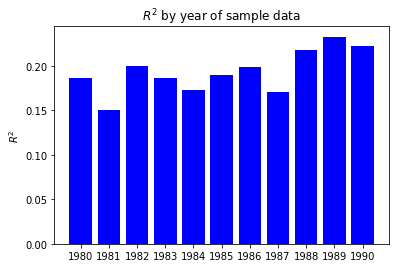

In [258]:
import matplotlib.ticker as mticker

fig, ax = plt.subplots()
ax.bar(r2_by_year.keys(), r2_by_year.values(), color='b')  # xticks=r2_by_year.keys()
myLocator = mticker.MultipleLocator(1)
ax.xaxis.set_major_locator(myLocator)

plt.title('$R^2$ by year of sample data')
plt.ylabel('$R^2$');

<hr style="height:5px;margin:auto;width:100%"/>
<hr style="height:5px;margin:auto;width:100%"/>
<hr style="height:5px;margin:auto;width:100%"/>

# Part II: Add categorical features for which people are involved
* Principals match
* Directors match
* Writers match

## Principals match

In [ ]:
principals_80s = set()
for principals_csv in movie_model_80s_df['principalCast']:
    principals_new = set(principals_csv.split(','))
    principals_80s = principals_80s.union(principals_new)
principals = sorted(filter(lambda p: len(p) > 0, principals_80s))

In [ ]:
for principal in principals_80s:
    key = 'is_principal__' + principal
    if not key in movie_model_80s_df.columns:
        movie_model_80s_df[key] = movie_model_80s_df['principal_cast'].str.contains(principal)

## Directors match

In [ ]:
directors_80s = set()
for directors_csv in movie_model_80s_df['directors']:
    directors_new = set(directors_csv.split(','))
    directors_80s = directors_80s.union(directors_new)
directors_80s = sorted(filter(lambda d: len(d) > 0, directors_80s))

In [ ]:
len(directors_80s)

In [ ]:
director2titleCount = defaultdict(int)
for k, row in movie_model_80s_df.iterrows():
    directors = row['directors'].split(',')
    for director in directors:
        director2titleCount[director] += 1

In [ ]:
director2titleCount

In [ ]:
for director in directors_80s:
    key = 'has_director__' + director
    if not key in movie_model_df.columns:
        def contains_director(ds):
            return director in ds
        movie_model_80s_df[key] = movie_model_80s_df['directors'].apply(contains_director)

## Writers match

In [ ]:
writers_80s = set()
for writers_csv in movie_model_80s_df['writers']:
    writers_new = set(writers_csv.split(','))
    writers_80s = writers_80s.union(writers_new)
writers_80s = sorted(filter(lambda w: len(w) > 0, writers_80s))

In [ ]:
len(writers_80s)

In [ ]:
writer2titleCount = defaultdict(int)
for k, row in movie_model_80s_df.iterrows():
    writers = row['writers'].split(',')
    for writer in writers:
        writer2titleCount[writer] += 1

In [ ]:
writer2titleCount

In [ ]:
for writer in writers_80s:
    key = 'has_writer__' + writer
    if not key in movie_model_df.columns:
        def contains_writer(ws):
            return writer in ws
        movie_model_80s_df[key] = movie_model_80s_df['writers'].apply(contains_writer)

<hr style="height:5px;margin:auto;width:100%"/>
<hr style="height:5px;margin:auto;width:100%"/>
<hr style="height:5px;margin:auto;width:100%"/>

# Part III: Merge in text stems from TMDB and Wikipedia

# Part III: Merge in TMDB data sources

In [ ]:
TMDB_MOVIE_IDS_PATH = TMDB_DIR + 'movie_ids_' + TMDB_DATE + '.json'

TMDB_DETAILS_PATH = SRC_DIR + 'details.json'
TMDB_DETAIL_ERRORS_PATH = SRC_DIR + 'detail_errors.log'
TMDB_KEYWORDS_PATH = SRC_DIR + 'keywords.json'
TMDB_KEYWORD_ERRORS_PATH = SRC_DIR + 'keyword_errors.log'

<hr style="height:3px;margin:auto;width:75%"/>

In [ ]:
tmdb_movies_raw_df = pd.read_json(TMDB_MOVIE_IDS_PATH, lines=True)

In [ ]:
tmdb_movies_raw_df.shape

In [ ]:
tmdb_movies_raw_df.dtypes

In [ ]:
tmdb_movies_raw_df.sample(5)

<hr style="height:3px;margin:auto;width:75%"/>

In [ ]:
tmdb_details_raw_df = pd.read_json(TMDB_DETAILS_PATH, lines=True)

In [ ]:
tmdb_details_raw_df.shape

In [ ]:
tmdb_details_raw_df[tmdb_details_raw_df['original_language'] == 'en'].shape[0]

In [ ]:
tmdb_details_raw_df.dtypes

In [ ]:
# This movie does not have a value for the imdb_id FK.
tmdb_details_raw_df[tmdb_details_raw_df['id'] == 252672]

In [ ]:
tmdb_details_raw_df.sample(5)

In [ ]:
tmdb_details_raw_df['overview'].sample(5)

<hr style="height:3px;margin:auto;width:10%"/>
<hr style="height:5px;margin:auto;width:25%"/>
<hr style="height:3px;margin:auto;width:10%"/>

In [ ]:
# tmdb_details_filtered_df = tmdb_details_raw_df[31091:31092].copy()
tmdb_details_filtered_df = tmdb_details_raw_df[['id', 'imdb_id', 'original_language', 'overview']].copy()

In [ ]:
tmdb_details_filtered_df['imdb_id'] = tmdb_details_filtered_df['imdb_id'].fillna('None')
tmdb_details_mask = (
    (~ (tmdb_details_filtered_df['imdb_id'] == ''))
    & (~ (tmdb_details_filtered_df['imdb_id'].str.contains('None')))
)
tmdb_details_filtered_df = tmdb_details_filtered_df[tmdb_details_mask]

In [ ]:
tmdb_details_filtered_df.shape[0]

In [ ]:
tmdb_details_filtered_df.dtypes

In [ ]:
tmdb_details_filtered_df.sample(5)

<hr style="height:3px;margin:auto;width:75%"/>

In [ ]:
tmdb_keywords_raw_df = pd.read_json(TMDB_KEYWORDS_PATH, lines=True)

In [ ]:
tmdb_keywords_raw_df.shape

In [ ]:
tmdb_keywords_raw_df.dtypes

In [ ]:
tmdb_keywords_raw_df.sample(5)

<hr style="height:3px;margin:auto;width:10%"/>
<hr style="height:5px;margin:auto;width:25%"/>
<hr style="height:3px;margin:auto;width:10%"/>

In [ ]:
tmdb_keywords_cooked_df = tmdb_keywords_raw_df.copy()

In [ ]:
def json_to_keywords(jsn):
    keywords = ' '.join([d['name'] for d in jsn])
    return keywords

<hr style="height:3px;margin:auto;width:10%"/>
<hr style="height:5px;margin:auto;width:25%"/>
<hr style="height:3px;margin:auto;width:10%"/>

In [ ]:
movie_stats_df = movie_stats_df.merge(tmdb_details_filtered_df, how='inner', left_on='tconst', right_on='imdb_id')

In [ ]:
movie_stats_df.columns

In [ ]:
movie_stats_df = movie_stats_df.merge(tmdb_keywords_cooked_df, how='inner', on='id')

In [ ]:
movie_stats_df.columns

In [ ]:
movie_stats_df[:5]['keywords']

<hr style="height:3px;margin:auto;width:10%"/>
<hr style="height:5px;margin:auto;width:25%"/>
<hr style="height:3px;margin:auto;width:10%"/>

## Event stems match

* Topicality (event stem match)

In [ ]:
movie_model_80s_df['movie_words'] = (movie_model_80s_df['overview'] 
                                     + ' ' 
                                     + movie_model_80s_df['keywords'])

stemmer = PorterStemmer()
def get_stems(s):
    return ' '.join(map(stemmer.stem, s.split()))

movie_model_80s_df['movie_stems'] = movie_model_80s_df['movie_words'].map(get_stem)

for year in range(1950, 2018):  
    key = 'year_' + str(year) + '_is_topical'
    if not key in movie_model_80s_df.columns:
        def is_topical(movie_stems):
            result = set(movie_stems.split()).intersection(year2eventStems[year])
            return 1 if result else 0
        movie_model_80s_df[key] = movie_model_80s_df['movie_stems'].map(is_topical)

In [ ]:
def yearRelTerm2stemColName(s):
    return 'year_' + s + '_is_topical'

delta_year_terms = 'neg5 neg4 neg3 neg2 neg1 zero pos1 pos2 pos3 pos4 pos5'.split()
delta_year_stem_colnames = list(map(yearRelTerm2stemColName, year_rel_terms))

In [ ]:
for delta_year in range(-5, 6):
    new_key = delta_year_stem_colnames[delta_year + 5]
    if not new_key in movie_model_80s_df.columns:
        delta_year_stems = []
        for row_num in range(len(movie_model_80s_df['start_year'])):
            start_year = movie_model_80s_df['start_year'][row_num]
            new_year = start_year + delta_year
            if 1875 <= new_year <= 2017:
                old_key = 'year_' + str(new_year) + '_is_topical'
                is_topical = movie_model_80s_df[old_key][row_num]
                delta_year_stems.append(is_topical)
            else:
                delta_year_stems.append(0)
        movie_model_80s_df[new_key] = pd.Series(delta_year_stems)

In [ ]:
cntr_year_zero_is_topical = Counter(movie_model_df['year_zero_is_topical'])

In [ ]:
is_topical_fraction = cntr_year_zero_is_topical[1] / sum(cntr_year_zero_is_topical.values())
is_topical_fraction

<hr style="height:3px;margin:auto;width:10%"/>
<hr style="height:5px;margin:auto;width:25%"/>
<hr style="height:3px;margin:auto;width:10%"/>

# Part III: Regression

# TODO